In [112]:
import numpy as np
import pickle
from scipy.io import savemat, loadmat
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, f1_score
from matplotlib.colors import Normalize
from helpers import *

In [72]:
def generate_ground_truth(comm_sizes, method = 'scattered', pad = False, community_operation = 'grow'):
    ##genertaes community labels according to two methods one in which the rest of the network except the planted communities
    # are scattered i.e. they all have their own community or they are all in one community, integrated.
    if community_operation == 'grow':
        layers = len(comm_sizes)
        if method == 'scattered':
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + list(np.arange(1, sum(comm_sizes[1:])+1))
            
            truth_labels_tip = truth_labels
                     
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + truth_labels_tip[sum(comm_sizes[:j]):]
            
            truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
            
            if pad:
                truth_labels = truth_labels_tip + truth_labels
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]  
        
        if method == 'integrated':
        
            truth_labels = [0 for i in range(sum(comm_sizes[:1]))] + [1 for i in range(sum(comm_sizes[1:]))]
            if pad: truth_labels = truth_labels + truth_labels
            for j in range(2,layers):
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:j]))] + [1 for i in range(sum(comm_sizes[j:]))]

            if pad:
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                truth_labels = truth_labels + [0 for i in range(sum(comm_sizes[:layers]))]
                
    elif community_operation == 'merge': ##only for two layers
        truth_labels = []
        
        for j,f in enumerate(comm_sizes[0]):
            truth_labels = truth_labels + [j for k in range(f)]
    
        for j,f in enumerate([6,3,7]):##communities that are merged in the first layer are assigned one of the labels of 
            #merged communities 
            truth_labels = truth_labels + [f for i in range(comm_sizes[1][j])]
            
        if pad:
            l1 = truth_labels[:sum(comm_sizes[0])]
            l2 = truth_labels[sum(comm_sizes[0]):]
            truth_labels = l1 + truth_labels +l2
    return(truth_labels)

# DONT RUN This part

[11, 16, 9, 9, 9, 14, 12]

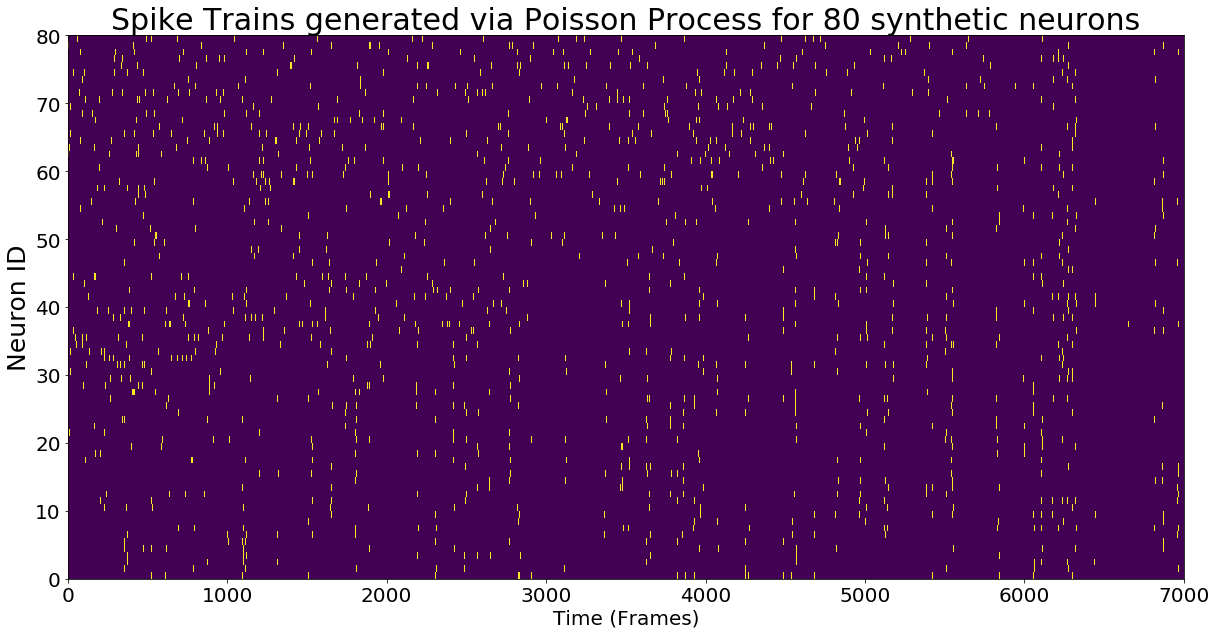

In [9]:
fixed_size = int(abs(np.random.normal(30,10)))
spike_rate = int(abs(np.random.normal(20,8)))# spike rate per commiunity
layers = 7

path = '/Users/bengieru/Desktop/DPPM/analysis/'
case = 'G_ESCR/'

G_ESCR_comm_size = [int(np.random.power(3/2)*20) for i in range(layers)]
spike_rates = [int(abs(np.random.normal(20,8))) for i in range(layers)]

window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = True
num_neurons = sum(G_ESCR_comm_size)

G_ESCR_spikes = create_time_series('grow', G_ESCR_comm_size, spike_rates, windowsize = window_size, k = k)
G_ESCR_comm_size

In [10]:
num_neurons = sum(G_ESCR_comm_size)
layers = len(G_ESCR_comm_size)+2

binned_spikes_G_ESCR = bin_time_series(G_ESCR_spikes, window_size, gaussian = True, sigma = standard_dev)

adjacency_matrices = {}
for i in range(1,layers-1):
    adjacency_matrices['t%d'%i] = cross_correlation_matrix(binned_spikes_G_ESCR[i-1])[0]
if pad:
    adjacency_matrices['t%d'%0] = adjacency_matrices['t%d'%1]
    adjacency_matrices['t%d'%(layers-1)] = adjacency_matrices['t%d'%(layers-2)]

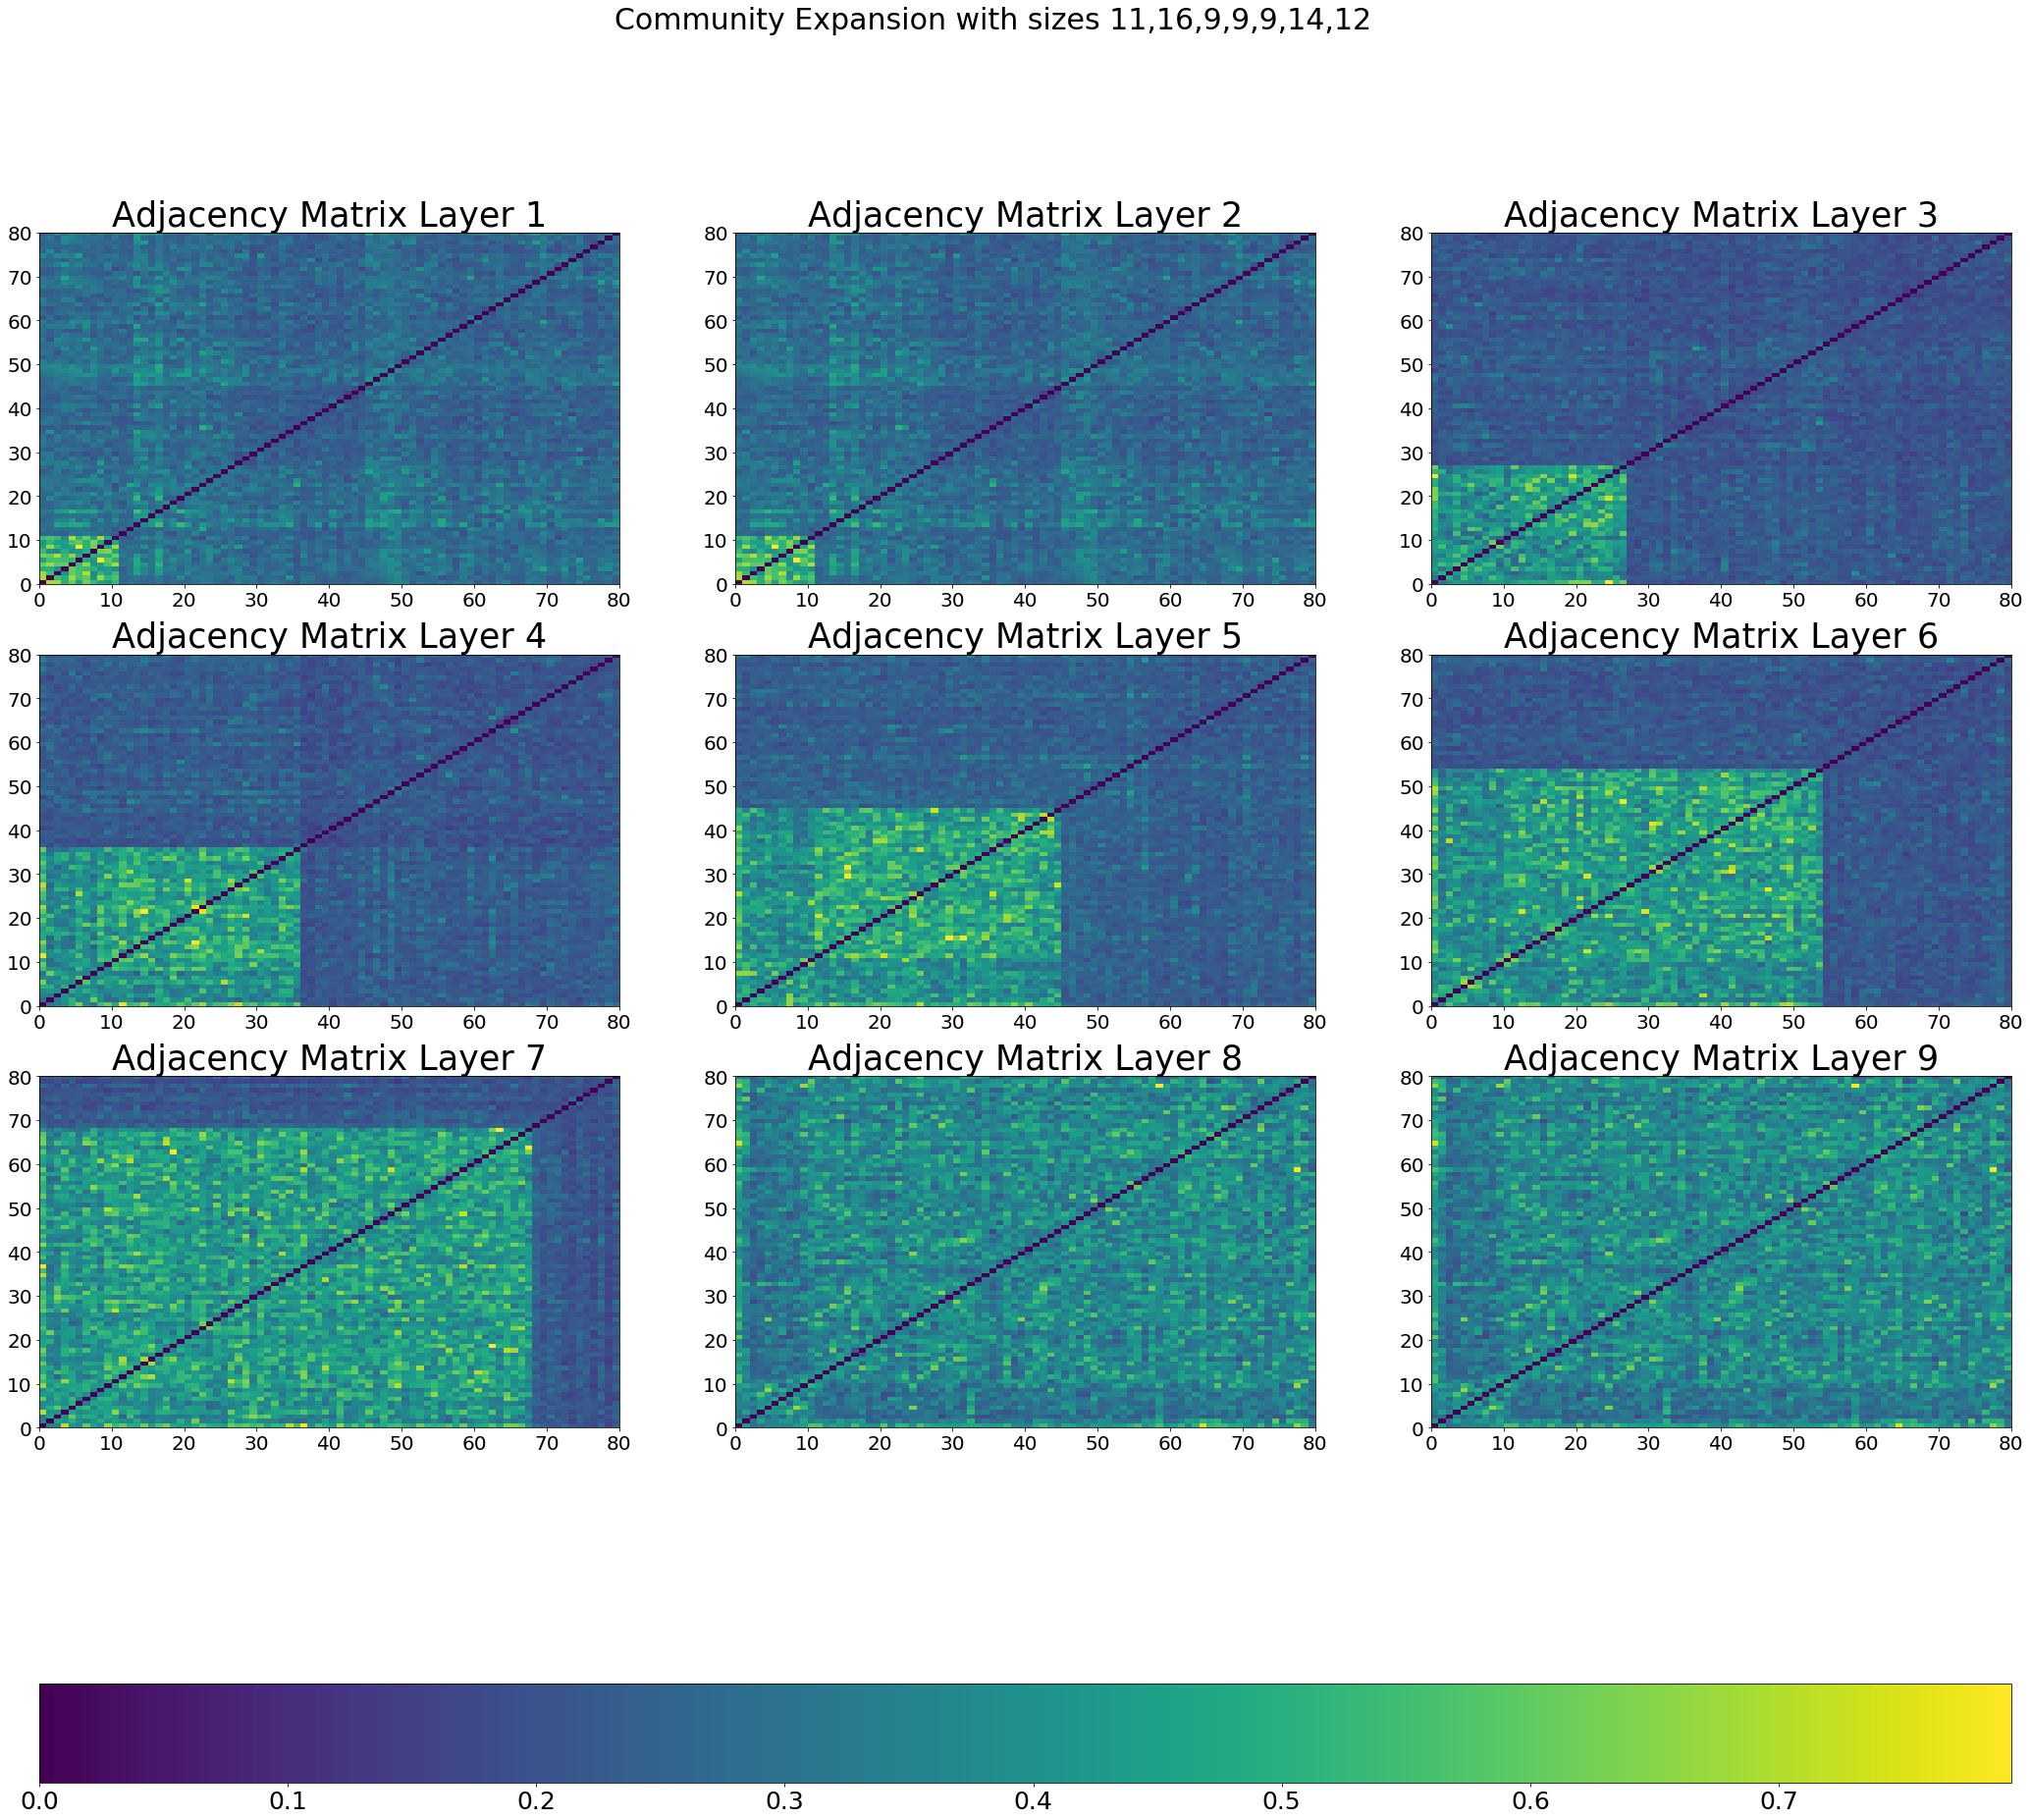

In [11]:
fig, ax = plt.subplots(3,3,figsize=(36,32))
for i in range(3):
    for j in range(3):
        k = ax[i][j].imshow(adjacency_matrices['t%d'%(i*3+j)], 
                            origin = 'lower', 
                            interpolation = 'nearest',
                            aspect = 'auto',
                            extent = [0,num_neurons,0,num_neurons])
        ax[i][j].set_title("Adjacency Matrix Layer %d"%(i*3+j+1), fontsize = 35)
        ax[i][j].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i][j].tick_params(axis = 'both', labelsize = 20)
fig.suptitle('Community Expansion with sizes %d,%d,%d,%d,%d,%d,%d'%(G_ESCR_comm_size[0],G_ESCR_comm_size[1],G_ESCR_comm_size[2],G_ESCR_comm_size[3],G_ESCR_comm_size[4],G_ESCR_comm_size[5],G_ESCR_comm_size[6]), fontsize = 30)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25)

In [12]:
thresholded_adjacencies = {}
threshs = np.linspace(0.05,0.6,12)
for i,e in enumerate(threshs):
    one_set = []
    for j in range(layers):
        one_set.append(binarize(adjacency_matrices['t%d'%j],e))
    thresholded_adjacencies['T%d'%i] = one_set
arr ={}
arr['TA'] = thresholded_adjacencies

In [13]:
savemat(path+case+'G_ESCR_adjacencies.mat', arr)

## Load data

In [73]:
G_ESCR_comm_size = [11,16,9,9,9,14,12]
num_neurons = sum(G_ESCR_comm_size)
threshs = np.linspace(0.05,0.5,10)
path = '/Users/bengieru/MLN/Results/Comparison/G_ESCR/DPPM/'

In [74]:
communities = loadmat(path + 'communitites_G_ESCR.mat')
vertices = loadmat(path + 'vertices_G_ESCR.mat')

In [184]:
labels_k_2 = {}
labels_k_3 = {}
for i,e in enumerate(threshs):
    li2 = []
    li3 = []
    for j in range(9):
        overlapping_partition2 = random.randint(0,vertices['v_G_ESCR'][0][0][i][0][0][0][j].shape[0]-1)
        overlapping_partition3 = random.randint(0,vertices['v_G_ESCR'][0][0][i][0][1][0][j].shape[0]-1)
        li2 = li2 + list(vertices['v_G_ESCR'][0][0][i][0][0][0][j][overlapping_partition2])
        li3 = li3 + list(vertices['v_G_ESCR'][0][0][i][0][1][0][j][overlapping_partition3])
    labels_k_2['%d'%i] = li2
    labels_k_3['%d'%i] = li3

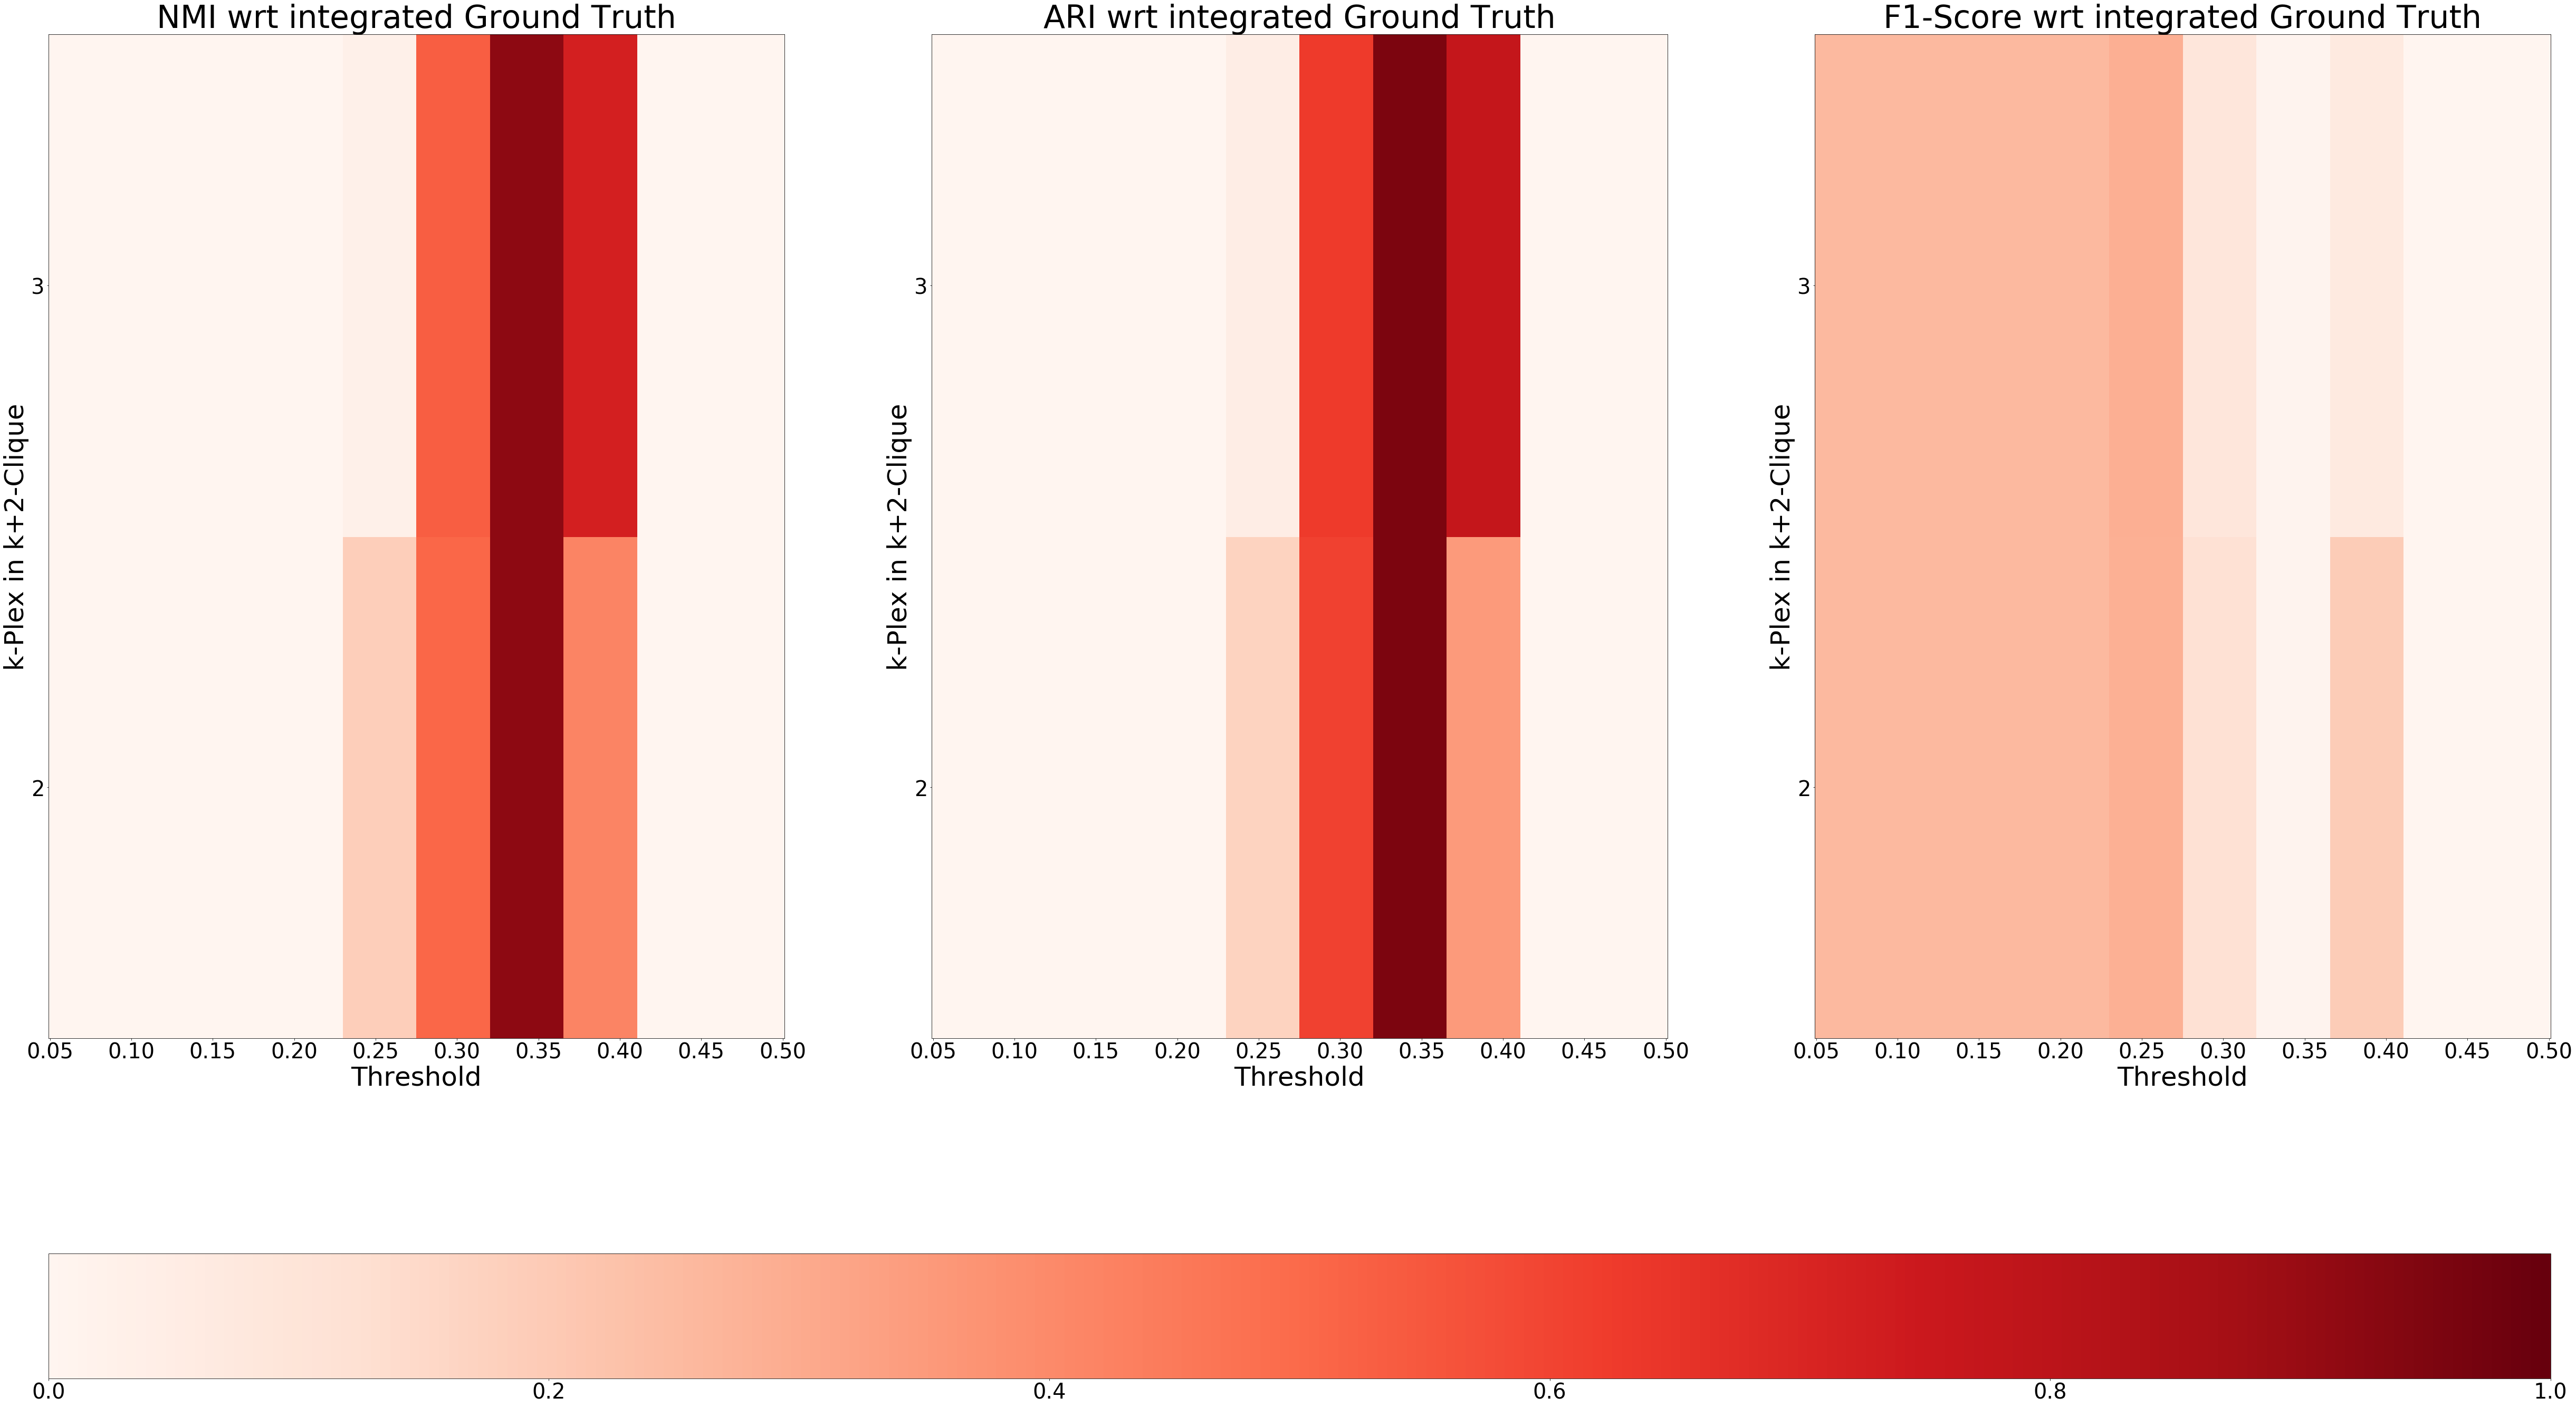

In [185]:
NMI1 = np.zeros((2, len(threshs)))
ARI1 = np.zeros((2, len(threshs)))
F1S1 = np.zeros((2, len(threshs)))
truth = 'integrated'

true_labels_scat = generate_ground_truth(G_ESCR_comm_size, method = 'scattered', pad = True, community_operation = 'grow')
true_labels_integ = generate_ground_truth(G_ESCR_comm_size, method = 'integrated', pad = True, community_operation = 'grow')

    
for j in range(len(threshs)-2):
    NMI1[0][j] = normalized_mutual_info_score(true_labels_integ, labels_k_2['%d'%j], average_method = 'max')
    NMI1[1][j] = normalized_mutual_info_score(true_labels_integ, labels_k_3['%d'%j], average_method = 'max')


    ARI1[0][j] = adjusted_rand_score(true_labels_integ, labels_k_2['%d'%j])
    ARI1[1][j] = adjusted_rand_score(true_labels_integ, labels_k_3['%d'%j])
    
    F1S1[0][j] = f1_score(true_labels_integ, labels_k_2['%d'%j], average = 'weighted')
    F1S1[1][j] = f1_score(true_labels_integ, labels_k_3['%d'%j], average = 'weighted')
        
fig,ax = plt.subplots(1,3, figsize = (85, 50))
normalize = Normalize(vmin=0, vmax=1)
c = ax[0].imshow(NMI1, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto', norm = normalize, 
                 extent = [threshs[0]-0.001, threshs[-1]+0.001, 2-0.5, 3+0.5])

c = ax[1].imshow(ARI1, origin = 'lower', interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [threshs[0]-0.001, threshs[-1]+0.001, 2-0.5, 3+0.5])

c = ax[2].imshow(F1S1, origin = 'lower',interpolation = 'none', cmap = 'Reds', aspect = 'auto',norm = normalize,
                 extent = [threshs[0]-0.001, threshs[-1]+0.001, 2-0.5, 3+0.5])

ax[0].set_title('NMI wrt %s Ground Truth'%truth, fontsize = 60)
ax[0].set_xlabel('Threshold', fontsize = 50)
ax[0].set_ylabel('k-Plex in k+2-Clique', fontsize = 50)
ax[0].set_xticks([i*0.05 for i in range(1,11)])
ax[0].set_yticks([2,3])
ax[0].tick_params(axis = 'both', labelsize = 40)

ax[1].set_title('ARI wrt %s Ground Truth'%truth, fontsize = 60)
ax[1].set_xlabel('Threshold', fontsize = 50)
ax[1].set_ylabel('k-Plex in k+2-Clique', fontsize = 50)
ax[1].set_xticks([i*0.05 for i in range(1,11)])
ax[1].set_yticks([2,3])
ax[1].tick_params(axis = 'both', labelsize = 40)

ax[2].set_title('F1-Score wrt %s Ground Truth'%truth, fontsize = 60)
ax[2].set_xlabel('Threshold', fontsize = 50)
ax[2].set_ylabel('k-Plex in k+2-Clique', fontsize = 50)
ax[2].set_xticks([i*0.05 for i in range(1,11)])
ax[2].set_yticks([2,3])
ax[2].tick_params(axis = 'both', labelsize = 40)
    
cbar = fig.colorbar(c, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 40) 

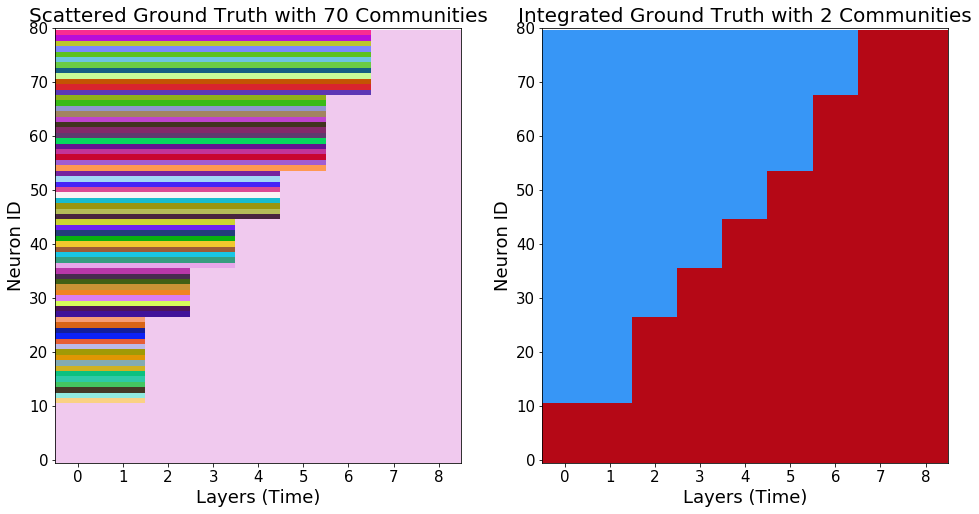

In [187]:
display_truth(G_ESCR_comm_size, 'grow')